# Classification Project

## Imports

In [342]:
import pandas as pd
import numpy as np


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV,  Ridge, LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn import neighbors
from mlxtend.classifier import StackingClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [341]:
pip install mlxtend 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -U imbalanced-learn

In [267]:
pip install xgboost

## Reading Data

Reading churn data from csv file.

In [2]:
churn_df = pd.read_csv('Churn Modeling.csv')

In [3]:
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Cleaning the data

#### Checking for nulls.

In [26]:
churn_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There is no null values in the dataset.

#### Checking for duplicates in `CustomerId` column.

In [29]:
(churn_df
 .groupby(["CustomerId"])
 .Surname.count()
 .reset_index()
 .sort_values("Surname", ascending=False)).head()

,CustomerId,Surname
0,15565701,1
6670,15732281,1
6663,15732199,1
6664,15732202,1
6665,15732235,1


There are no duplicate rows in the dataset.

#### Dropping the unwanted columns (columns that have no value):

In [115]:
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [116]:
churn_df = churn_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [117]:
churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## EDA

#### Exploring the target `Exited` column:

Checking the balance of the target column `Exited`.

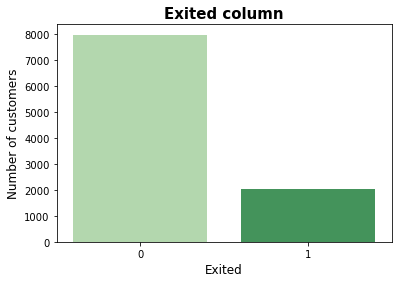

In [310]:
Exited_col = sns.countplot(x="Exited", data=churn_df, palette="Greens")

Exited_col.set_xlabel('Exited', size= 12) 
Exited_col.set_ylabel('Number of customers', size= 12)
Exited_col.set_title('Exited column', weight = 'bold', size =15)
Exited_col.figure.savefig("ExitedCol.png")

By looking at the bar chart above, it seems that the target column `Exited` might be imbalanced.

In [43]:
churn_df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [47]:
churn_df['Exited'].value_counts(normalize=True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

The percentage difference between `0` and `1` values is more than 20%, which indicates the the target column `Exited` is imbalanced.

#### Exploring `Age` column:

In [68]:
# Age_0 = churn_df[churn_df['Exited'] == 0 ]
# Age_1 = churn_df[churn_df['Exited'] == 1 ]

Text(0.5, 1.0, 'Age Column')

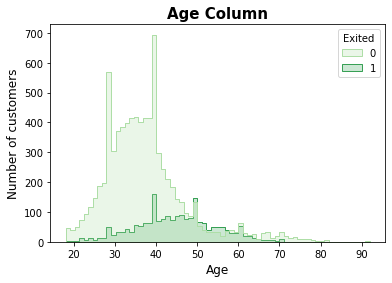

In [277]:
Age_col = sns.histplot(churn_df, x="Age", hue="Exited", palette="Greens", element="step")

Age_col.set_xlabel('Age', size= 12) 
Age_col.set_ylabel('Number of customers', size= 12)
Age_col.set_title('Age Column', weight = 'bold', size =15)

The graph of the non-churn is skewed to the right which tells us that the younger people (30 ~ 40) dont tend to churn, unlike the lder people (40 ~ 60).

#### Exploring `Balance` column:

Text(0.5, 1.0, 'Balance Column')

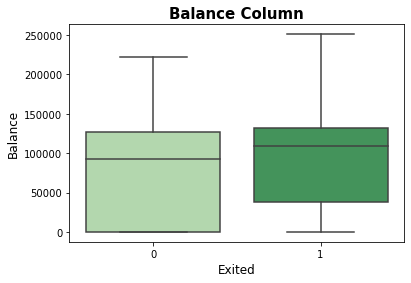

In [278]:
Balance_col = sns.boxplot(y= 'Balance', x='Exited', data= churn_df, palette = 'Greens')

Balance_col.set_xlabel('Exited', size= 12) 
Balance_col.set_ylabel('Balance', size= 12)
Balance_col.set_title('Balance Column', weight = 'bold', size =15)

There are no outliers in `Balance` column.

#### Exploring `Gender` column:

Text(0.5, 1.0, 'Gender Column')

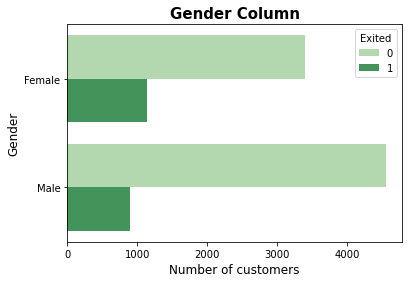

In [305]:
Gender_col = sns.countplot(y="Gender", hue = 'Exited', data=churn_df, palette="Greens")

Gender_col.set_xlabel('Number of customers', size= 12) 
Gender_col.set_ylabel('Gender', size= 12)
Gender_col.set_title('Gender Column', weight = 'bold', size =15)

By looking at the graph, it seems that Female customers tend to churn more than Male customers.

#### Exploring `HasCrCard` column:

Text(0.5, 1.0, 'Has Credit Card Column')

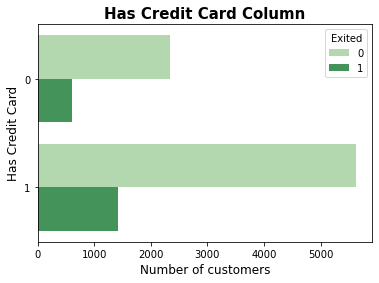

In [306]:
HasCrCard_col = sns.countplot(y="HasCrCard",hue = 'Exited', data=churn_df, palette="Greens")

HasCrCard_col.set_xlabel('Number of customers', size= 12) 
HasCrCard_col.set_ylabel('Has Credit Card', size= 12)
HasCrCard_col.set_title('Has Credit Card Column', weight = 'bold', size =15)

More than half of the bank customers have credit cards. Most of the customers who have credit cards had left he bank.

#### Exploring `Geography` column:

Text(0.5, 1.0, 'Geography Column')

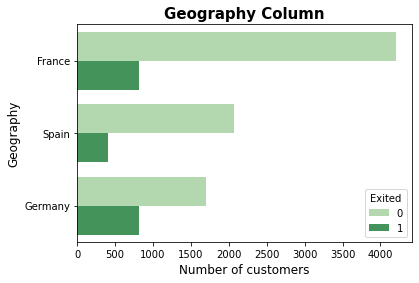

In [307]:
Geography_col = sns.countplot(y="Geography",hue= 'Exited', data=churn_df, palette="Greens")

Geography_col.set_xlabel('Number of customers', size= 12) 
Geography_col.set_ylabel('Geography', size= 12)
Geography_col.set_title('Geography Column', weight = 'bold', size =15)

The majority of the bank customers are from France, the rest are from Spain and Germany. 

## Formatting the data

In [49]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


All the columns has the correct format, threfore the data does not need any formatting.

## Baseline model

In [131]:
X = churn_df.drop(['Exited', 'Geography', 'Gender'], axis = 1)
y = churn_df['Exited']

X,X_test,y,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

In [132]:
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

logreg.score(X_train, y_train)

0.7875

In [133]:
y_pred = logreg.predict(X_val)

In [139]:
print("Accuracy:",accuracy_score(y_val, y_pred))
print("Precision:",precision_score(y_val, y_pred))
print("Recall:",recall_score(y_val, y_pred))
print("F1 score:",f1_score(y_val, y_pred))

Accuracy: 0.786
Precision: 0.38461538461538464
Recall: 0.06053268765133172
F1 score: 0.10460251046025104


Text(33.0, 0.5, 'Actual')

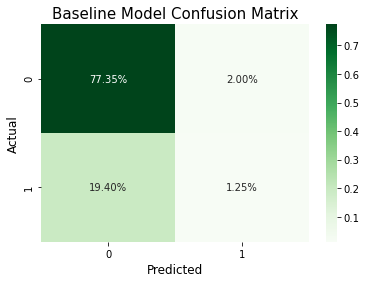

In [289]:
cm = confusion_matrix(y_val, y_pred)

baseline_cm = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')
baseline_cm.set_title('Baseline Model Confusion Matrix', size =15) 
baseline_cm.set_xlabel('Predicted', size= 12) 
baseline_cm.set_ylabel('Actual', size= 12)

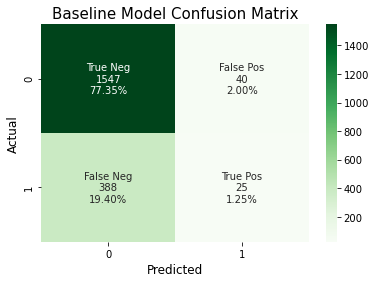

In [309]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
baseline_cm2 = sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')
baseline_cm2.set_title('Baseline Model Confusion Matrix', size =15) 
baseline_cm2.set_xlabel('Predicted', size= 12) 
baseline_cm2.set_ylabel('Actual', size= 12)
baseline_cm2.figure.savefig("BaselineCM.png")

## Feature Engineering

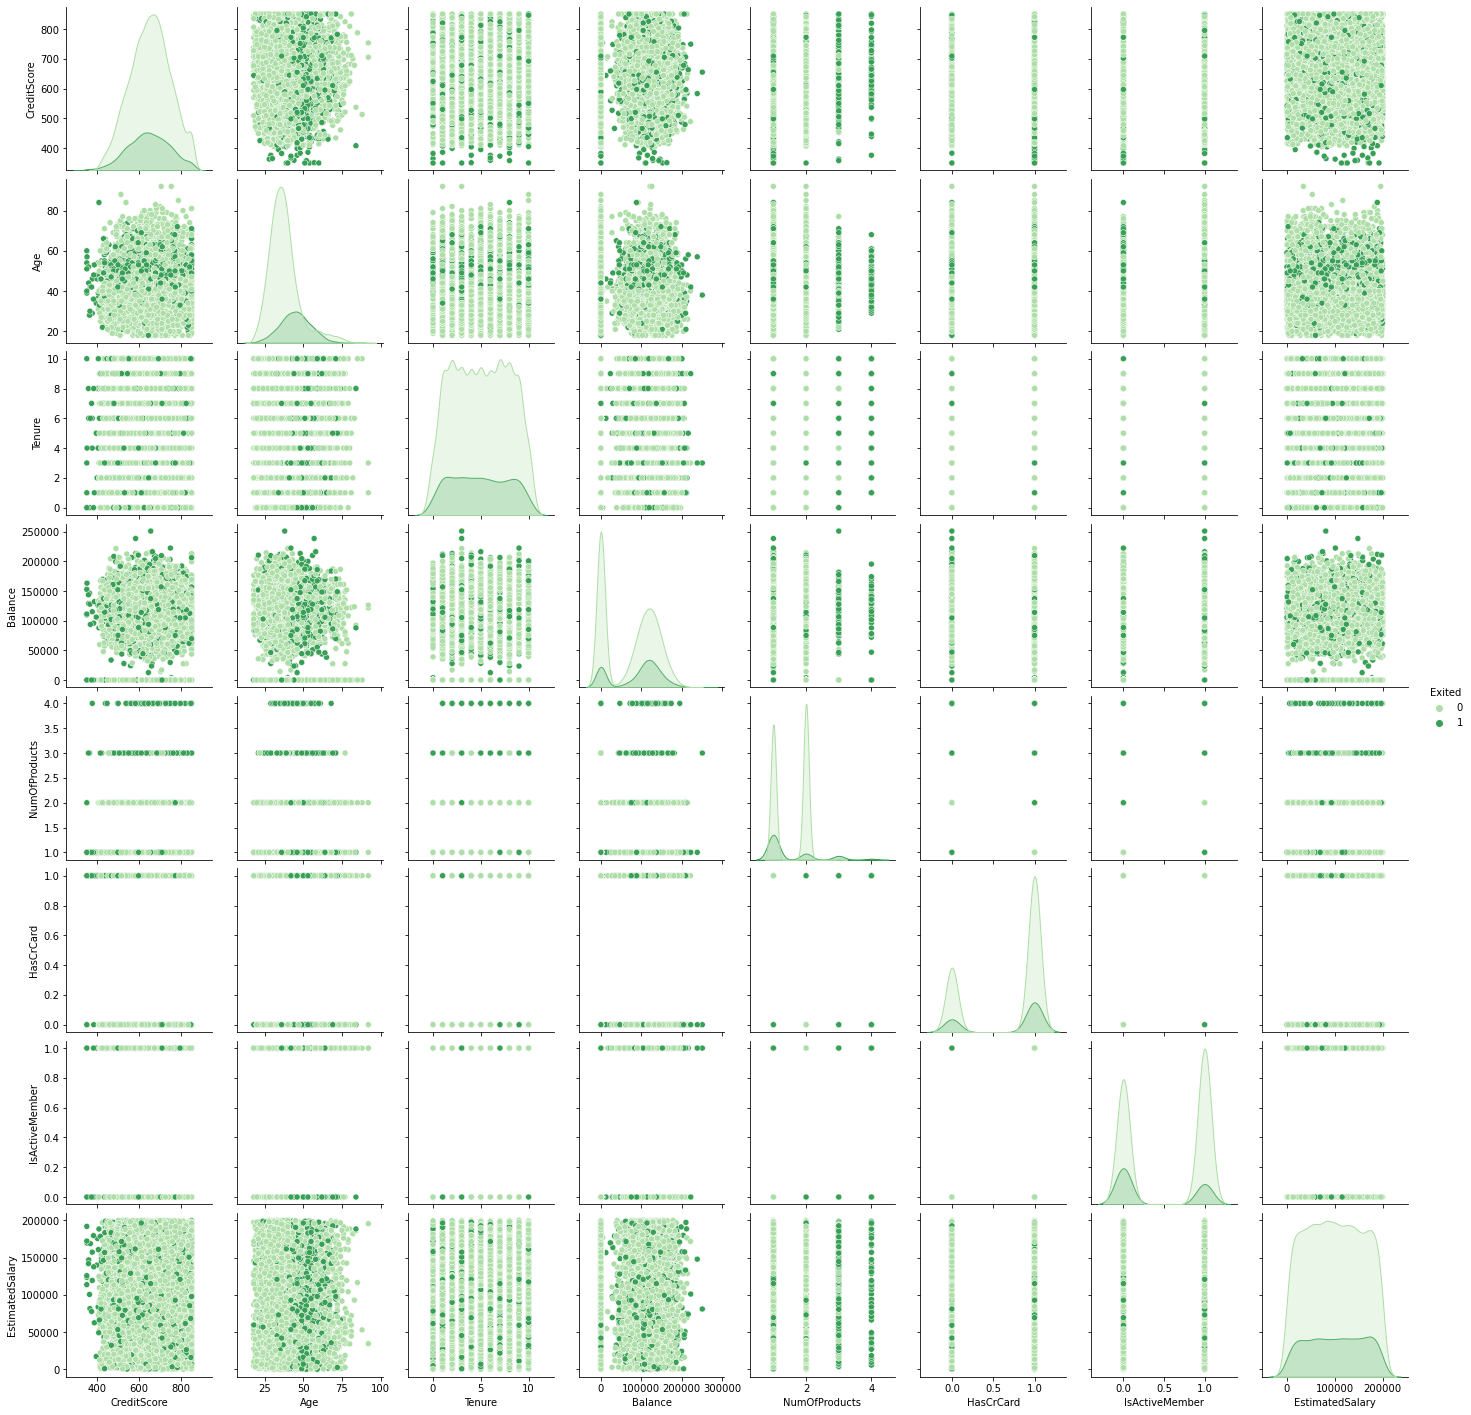

In [162]:
sns.pairplot(churn_df, hue= 'Exited', palette = 'Greens')

#### Transforming categorical data:

There are two categorical columns in the dataset, `Geography` and `Gender` columns. To be able to use their values in the models, I have to transform them using One-Hot Encoding.

In [165]:
categorical_data = churn_df[['Geography', 'Gender']]
categorical_data.head()

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


In [166]:
encoded_Geography = pd.get_dummies(categorical_data['Geography'])
encoded_Gender = pd.get_dummies(categorical_data['Gender'])

categorical_data = categorical_data.join(encoded_Geography)
categorical_data = categorical_data.join(encoded_Gender)

categorical_data.head()

,Geography,Gender,France,Germany,Spain,Female,Male
0,France,Female,1,0,0,1,0
1,Spain,Female,0,0,1,1,0
2,France,Female,1,0,0,1,0
3,France,Female,1,0,0,1,0
4,Spain,Female,0,0,1,1,0


Add the encoded columns to `churn_df` and assign it to a new dataframe `churn_cat_df`.

In [175]:
categorical_data = categorical_data.drop(['Geography', 'Gender'], axis = 1)

In [176]:
categorical_data.head()

,France,Germany,Spain,Female,Male
0,1,0,0,1,0
1,0,0,1,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,0,0,1,1,0


In [177]:
churn_cat_df = churn_df.join(categorical_data)

In [179]:
churn_cat_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


#### Try the baseline model with the new values:

In [182]:
X_cat = churn_cat_df.drop(['Exited', 'Geography', 'Gender'], axis = 1)
y_cat = churn_cat_df['Exited']

X_cat,X_test_cat,y_cat,y_test_cat = train_test_split(X_cat,y_cat,test_size=0.20,random_state=42)
X_train_cat,X_val_cat,y_train_cat,y_val_cat = train_test_split(X_cat,y_cat,test_size=0.25,random_state=42)

In [183]:
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_cat,y_train_cat)

logreg.score(X_train_cat, y_train_cat)

0.7878333333333334

In [184]:
y_pred_cat = logreg.predict(X_val_cat)

In [185]:
print("Accuracy:",accuracy_score(y_val_cat, y_pred_cat))
print("Precision:",precision_score(y_val_cat, y_pred_cat))
print("Recall:",recall_score(y_val_cat, y_pred_cat))
print("F1 score:",f1_score(y_val_cat, y_pred_cat))

Accuracy: 0.786
Precision: 0.38461538461538464
Recall: 0.06053268765133172
F1 score: 0.10460251046025104


The values did not have a significant change, due to target column `Exited` imbalance.

## Sloving class imbalance

- Using simple Oversampling:

In [206]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train_cat == 1)
n_neg = np.sum(y_train_cat == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_train_rs, y_train_rs = ROS.fit_resample(X_train_cat, y_train_cat)

lr = LogisticRegression() 
lr.fit(X_train_cat, y_train_cat)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, lr.predict(X_val_cat)), roc_auc_score(y_val_cat, lr.predict_proba(X_val_cat)[:,1]))) 

lr_os = LogisticRegression() 
lr_os.fit(X_train_rs, y_train_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, lr_os.predict(X_val_cat)), roc_auc_score(y_val_cat, lr_os.predict_proba(X_val_cat)[:,1])))

Simple Logistic Regression; Test F1: 0.105, Test AUC: 0.679
Logistic Regression on Oversampled Train Data; Test F1: 0.455, Test AUC: 0.714


C:\Users\SDAIA\anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (4924) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4769)
  warnings.warn(


The F1 score has increased from 0.105 to 0.455 using oversampling.

- Using SMOTE:

In [209]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_train_smote, y_train_smote = smote.fit_resample(X_train_cat, y_train_cat)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_train_smote, y_train_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, lr_smote.predict(X_val_cat)), roc_auc_score(y_val_cat, lr_smote.predict_proba(X_val_cat)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.469, Test AUC: 0.727


C:\Users\SDAIA\anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (4924) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4769)
  warnings.warn(


The F1 score has increased from 0.455 using Oversampling, to 0.469 using SMOTE.

- Using simple Undersampling:

In [212]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_cat, y_train_cat)

lr_us = LogisticRegression() 
lr_us.fit(X_train_res, y_train_res)

print('Logistic Regression on Undersampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, lr_us.predict(X_val_cat)), roc_auc_score(y_val_cat, lr_us.predict_proba(X_val_cat)[:,1])))

Logistic Regression on Undersampled Train Data; Test F1: 0.453, Test AUC: 0.713


The F1 score of Undersampling (0.453) is less than the F1 score of SMOTE (0.469) and simple Oversampling (0.455).

- Combining Undersampling and Oversampling:

In [253]:
# Oversampling
ros = imblearn.over_sampling.RandomOverSampler(random_state=42)
X_train_ou, y_train_ou = ros.fit_resample(X_train_cat, y_train_cat)


# Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_ou, y_train_ou = rus.fit_resample(X_train_ou, y_train_ou)


lr_ou = LogisticRegression() 
lr_ou.fit(X_train_ou, y_train_ou)


print('Logistic Regression on Oversampled and Undersampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, lr_ou.predict(X_val_cat)), roc_auc_score(y_val_cat, lr_ou.predict_proba(X_val_cat)[:,1])))

Logistic Regression on Oversampled and Undersampled Train Data; Test F1: 0.456, Test AUC: 0.714


The F1 score of Combining Undersampling and Oversampling is less than the F1 score of SMOTE.

In conclusion, The method that produce the best F1 score is Oversampling SMOTE.

## Experminting with different models:

- Modeling using DecisionTree:

In [376]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_smote, y_train_smote)

print('DecisionTree on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, dt_model.predict(X_val_cat)), roc_auc_score(y_val_cat, dt_model.predict_proba(X_val_cat)[:,1])))
print("Accuracy:",accuracy_score(y_val_cat, dt_model.predict(X_val_cat)))
print("Precision:",precision_score(y_val_cat, dt_model.predict(X_val_cat)))
print("Recall:",recall_score(y_val_cat, xgb_model.predict(X_val_cat)))

DecisionTree on SMOTE Train Data; Test F1: 0.505, Test AUC: 0.693
Accuracy: 0.7775
Precision: 0.4670781893004115
Recall: 0.549636803874092


F1 score of DecisionTree model is higher than LogisticRegression model

- Modeling using RandomForest:

In [378]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_smote, y_train_smote)

print('RandomForest on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, rf_model.predict(X_val_cat)), roc_auc_score(y_val_cat, rf_model.predict_proba(X_val_cat)[:,1])))
print("Accuracy:",accuracy_score(y_val_cat, rf_model.predict(X_val_cat)))
print("Precision:",precision_score(y_val_cat, rf_model.predict(X_val_cat)))
print("Recall:",recall_score(y_val_cat, rf_model.predict(X_val_cat)))

RandomForest on SMOTE Train Data; Test F1: 0.603, Test AUC: 0.855
Accuracy: 0.846
Precision: 0.6446280991735537
Recall: 0.5665859564164649


F1 score of RandomForest model is higher than DecisionTree model.

- Modeling using XGBoost:

In [379]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_smote, y_train_smote)

print('XGBoost on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, xgb_model.predict(X_val_cat)), roc_auc_score(y_val_cat, xgb_model.predict_proba(X_val_cat)[:,1])))
print("Accuracy:",accuracy_score(y_val_cat, xgb_model.predict(X_val_cat)))
print("Precision:",precision_score(y_val_cat, xgb_model.predict(X_val_cat)))
print("Recall:",recall_score(y_val_cat, xgb_model.predict(X_val_cat)))

C:\Users\SDAIA\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost on SMOTE Train Data; Test F1: 0.599, Test AUC: 0.853
Accuracy: 0.841
Precision: 0.6246719160104987
Recall: 0.576271186440678


F1 score of XGBoost model is better than DecisionTree model, but it is not as good as RandomForest model.

In conclusion, the highest F1 score model is RandomForest.

## Feature importance

Feature importance with LogisticRegression:

Feature: 0, Score: -0.00415
Feature: 1, Score: 0.06389
Feature: 2, Score: -0.00403
Feature: 3, Score: 0.00000
Feature: 4, Score: -0.00192
Feature: 5, Score: -0.00147
Feature: 6, Score: -0.00324
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00239
Feature: 9, Score: 0.00011
Feature: 10, Score: -0.00136
Feature: 11, Score: -0.00054
Feature: 12, Score: -0.00278


C:\Users\SDAIA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

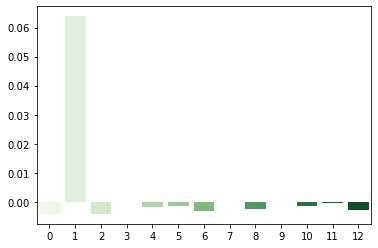

In [275]:
model = LogisticRegression()
# fit the model
model.fit(X_train_smote, y_train_smote)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance, palette = 'Greens')

In [257]:
X_train_smote.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,712,29,7,77919.78,1,1,0,122547.58,0,0,1,1,0
1,542,39,4,109949.39,2,1,1,41268.65,1,0,0,1,0
2,512,42,9,93955.83,2,1,0,14828.54,0,1,0,0,1
3,580,39,9,128362.59,1,1,0,86044.98,1,0,0,1,0
4,689,55,1,76296.81,1,1,0,42364.75,0,1,0,1,0


Feature importance with Decisiontree classifier:

Feature: 0, Score: 0.08283
Feature: 1, Score: 0.24129
Feature: 2, Score: 0.04457
Feature: 3, Score: 0.10904
Feature: 4, Score: 0.07774
Feature: 5, Score: 0.01115
Feature: 6, Score: 0.11571
Feature: 7, Score: 0.09183
Feature: 8, Score: 0.04029
Feature: 9, Score: 0.04666
Feature: 10, Score: 0.04919
Feature: 11, Score: 0.05757
Feature: 12, Score: 0.03215


C:\Users\SDAIA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

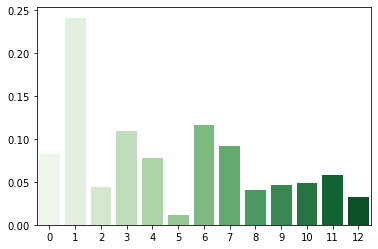

In [274]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train_smote, y_train_smote)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance, palette = 'Greens')

Feature importance with RandomForest classifier:

Feature: 0, Score: 0.09152
Feature: 1, Score: 0.20555
Feature: 2, Score: 0.05968
Feature: 3, Score: 0.09944
Feature: 4, Score: 0.09359
Feature: 5, Score: 0.01716
Feature: 6, Score: 0.08794
Feature: 7, Score: 0.09851
Feature: 8, Score: 0.06655
Feature: 9, Score: 0.03185
Feature: 10, Score: 0.04575
Feature: 11, Score: 0.04769
Feature: 12, Score: 0.05477


C:\Users\SDAIA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


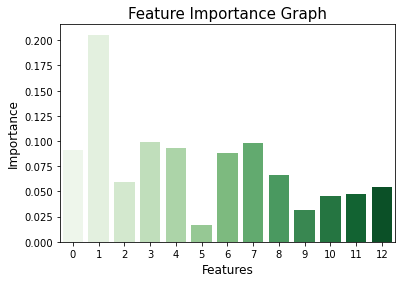

In [391]:
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train_smote, y_train_smote)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fi_RF = sns.barplot([x for x in range(len(importance))], importance, palette = 'Greens')
fi_RF.set_title('Feature Importance Graph', size =15)
fi_RF.set_xlabel('Features', size= 12) 
fi_RF.set_ylabel('Importance', size= 12)
fi_RF.figure.savefig("RandomForest_FI.png")

Feature importance with XGBoost:

C:\Users\SDAIA\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature: 0, Score: 0.00940
Feature: 1, Score: 0.05384
Feature: 2, Score: 0.01044
Feature: 3, Score: 0.01605
Feature: 4, Score: 0.08387
Feature: 5, Score: 0.01890
Feature: 6, Score: 0.17770
Feature: 7, Score: 0.01109
Feature: 8, Score: 0.06964
Feature: 9, Score: 0.11672
Feature: 10, Score: 0.09726
Feature: 11, Score: 0.25975
Feature: 12, Score: 0.07535


C:\Users\SDAIA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

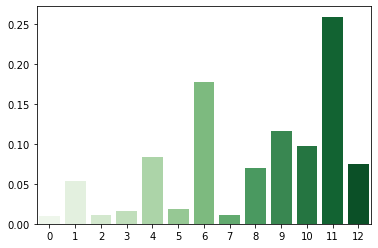

In [272]:
from xgboost import XGBClassifier

# define the model
model = XGBClassifier()
# fit the model
model.fit(X_train_smote, y_train_smote)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance, palette = 'Greens')

## Feature Selection

Apply feature selection on RandomForest model.

In [370]:
X_train_removed = X_train_smote.drop(['HasCrCard'], axis = 1)
X_val_removed = X_val_cat.drop(['HasCrCard'], axis = 1)

Trying random forest with feature selection:

In [371]:
rf_model_removed = RandomForestClassifier()
rf_model_removed.fit(X_train_removed, y_train_smote)

print('RandomForest on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val_cat, rf_model_removed.predict(X_val_removed)), roc_auc_score(y_val_cat, rf_model_removed.predict_proba(X_val_removed)[:,1])))
print("Accuracy:",accuracy_score(y_val_cat, rf_model_removed.predict(X_val_removed)))
print("Precision:",precision_score(y_val_cat, rf_model_removed.predict(X_val_removed)))
print("Recall:",recall_score(y_val_cat, rf_model_removed.predict(X_val_removed)))

RandomForest on SMOTE Train Data; Test F1: 0.618, Test AUC: 0.856
Accuracy: 0.85
Precision: 0.6514745308310992
Recall: 0.5883777239709443


Visualizing:

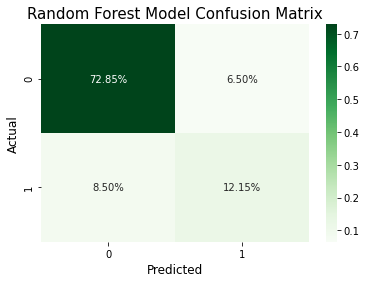

In [392]:
cm = confusion_matrix(y_val_cat, rf_model_removed.predict(X_val_removed))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')

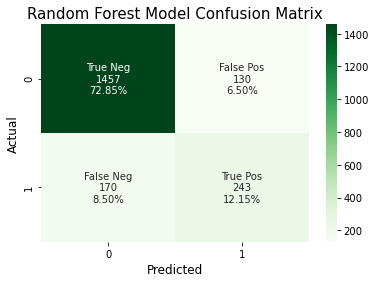

In [393]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

RF_model_cm = sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')
RF_model_cm.set_title('Random Forest Model Confusion Matrix', size =15) 
RF_model_cm.set_xlabel('Predicted', size= 12) 
RF_model_cm.set_ylabel('Actual', size= 12)
RF_model_cm.figure.savefig("RandomForestCM.png")

## Stacking models:

- Using Max Voting:

In [317]:
# Load pre-trained/tuned models
lr_model = LogisticRegression(solver="lbfgs", random_state=1)
knn_model = neighbors.KNeighborsClassifier()
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1)


model_names = ["lr_model", "knn_model", "rf_model", "et_model"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [319]:
for model_name in model_names:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train_smote, y_train_smote)

In [320]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_cat, y_val_cat)}')

lr_model score: 0.6665
knn_model score: 0.5755
rf_model score: 0.848
et_model score: 0.8435


In [323]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train_smote, y_train_smote)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1)

In [382]:
# get accuracy (model to beat: RF with 0.84 accuracy)
y_pred = voting_classifer.predict(X_val_cat)
# accuracy_score(y_val_cat, y_pred)
f1_score(y_val_cat, y_pred)

0.5743329097839898

- Using Average Voting:

In [329]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)
voting_classifer.fit(X_train_smote, y_train_smote)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft')

In [381]:
# Get accuracy (model to beat: RF with 0.84 accuracy)
y_pred = voting_classifer.predict(X_val_cat)
# accuracy_score(y_val_cat, y_pred)
f1_score(y_val_cat, y_pred)

0.5743329097839898

- Using Weighted Voting:

In [331]:
# create voting classifier
weights = [1.5,3.8,4.2,2.2]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,  #include weights
                                    n_jobs=-1)
voting_model.fit(X_train_smote, y_train_smote)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft', weights=[1.5, 3.8, 4.2, 2.2])

In [380]:
# Get accuracy (model to beat: RF with 0.84 accuracy)
y_pred = voting_model.predict(X_val_cat)
# accuracy_score(y_val_cat, y_pred)
f1_score(y_val_cat, y_pred)

0.5536869340232858

- Using Stacked Classifiers:

In [343]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)

In [344]:
stacked.fit(X_train_smote, y_train_smote)

StackingClassifier(classifiers=[LogisticRegression(random_state=1),
                                KNeighborsClassifier(),
                                RandomForestClassifier(random_state=1),
                                ExtraTreesClassifier(random_state=1)],
                   meta_classifier=LogisticRegression())

In [374]:
y_pred = stacked.predict(X_val_cat)
# accuracy_score(y_val_cat, y_pred)
f1_score(y_val_cat, y_pred)

0.5837696335078535